# Пример 1: моделирование спектроастрометрического эффекта

Для создания искусственных кадров с пространственно неразрешенной двойной системой используется модуль `SAModel`, включающий в себя `numpy` (импортируется как `np`) и `random`.

Спектроастрометрическая обработка данных - как реальных, так и искусственных - производится с использованием модуля `Spectroastrometry`, также включающего `numpy` и, кроме того, несколько отдельных функций: `matplotlib.pyplot` (импортируется как `plt`), `scipy.optimize.least_squares` и `scipy.special.erf`.

Перед моделированием кадра требуется указать параметры прибора, наблюдаемой системы и условий наблюдения.

**Важно:** в этой программе при каждом запуске генерируется кадр с новым спектром, линии в котором расположены случайным образом. Для каждого нового спектра нужно менять значения в ячейках 5 и 7. Поэтому перед запуском кода желательно целиком ознакомиться с содержимым этого блокнота.

In [1]:
from Spectroastrometry import *
from SAModel import *


image_size_X = 2000  # Размеры изображения в пикселях (NAXIS1)
image_size_Y = 400  # Размеры изображения в пикселях (NAXIS2)
CRVAL1 = 5000  # Стартовая длина волны
CDELT1 = 1  # Шаг по длине волны (дисперсия)
Y_est = 200  # Положение центра "опорного" спектра на кадре
pix_size = 0.37  # Угловой размер пикселя (arcsec)
sep = 0.07  # Смещение спектра 2 относительно спектра 1 (arcsec)
seeing = 1  # Размер атмосферных изображений (arcsec)
slit = 1  # Размер щели (arcsec)
RN = 3  # Шум считывания (ADU)
BN = 5  # Фон (ADU)

T1 = 5000  # Эффективная температура источника 1 (K)
T2 = 5000  # Эффективная температура источника 2 (K)
N_emission = 5  # Число линий излучения в спектре
N_absorption = 8  # Число линий поглощения в спектре
sigma_emission = 8  # Ширина линии излучения (Å)
sigma_absorption = 5  # Ширина линии поглощения (Å)
MinMag_emission = 0.1  # Минимальное отклонение линии излучения от континуума
MinMag_absorption = 0.1  # Минимальное отклонение линии поглощения от континуума
MaxMag_emission = 0.5  # Максимальное отклонение линии излучения от континуума
MaxMag_absorption = 0.5  # Максимальное отклонение линии поглощения от континуума
MaxADU1 = 4000  # Максимальное число отсчетов для спектра 1
MaxADU2 = 6000  # Максимальное число отсчетов для спектра 2

Создание кадра "с нуля" осуществляется функцией `Frame_model`, которая возвращает сам кадр, вид функции рассеяния точки, а также спектры наблюдаемых источников в виде массивов, содержащих длины волн и интенсивности.

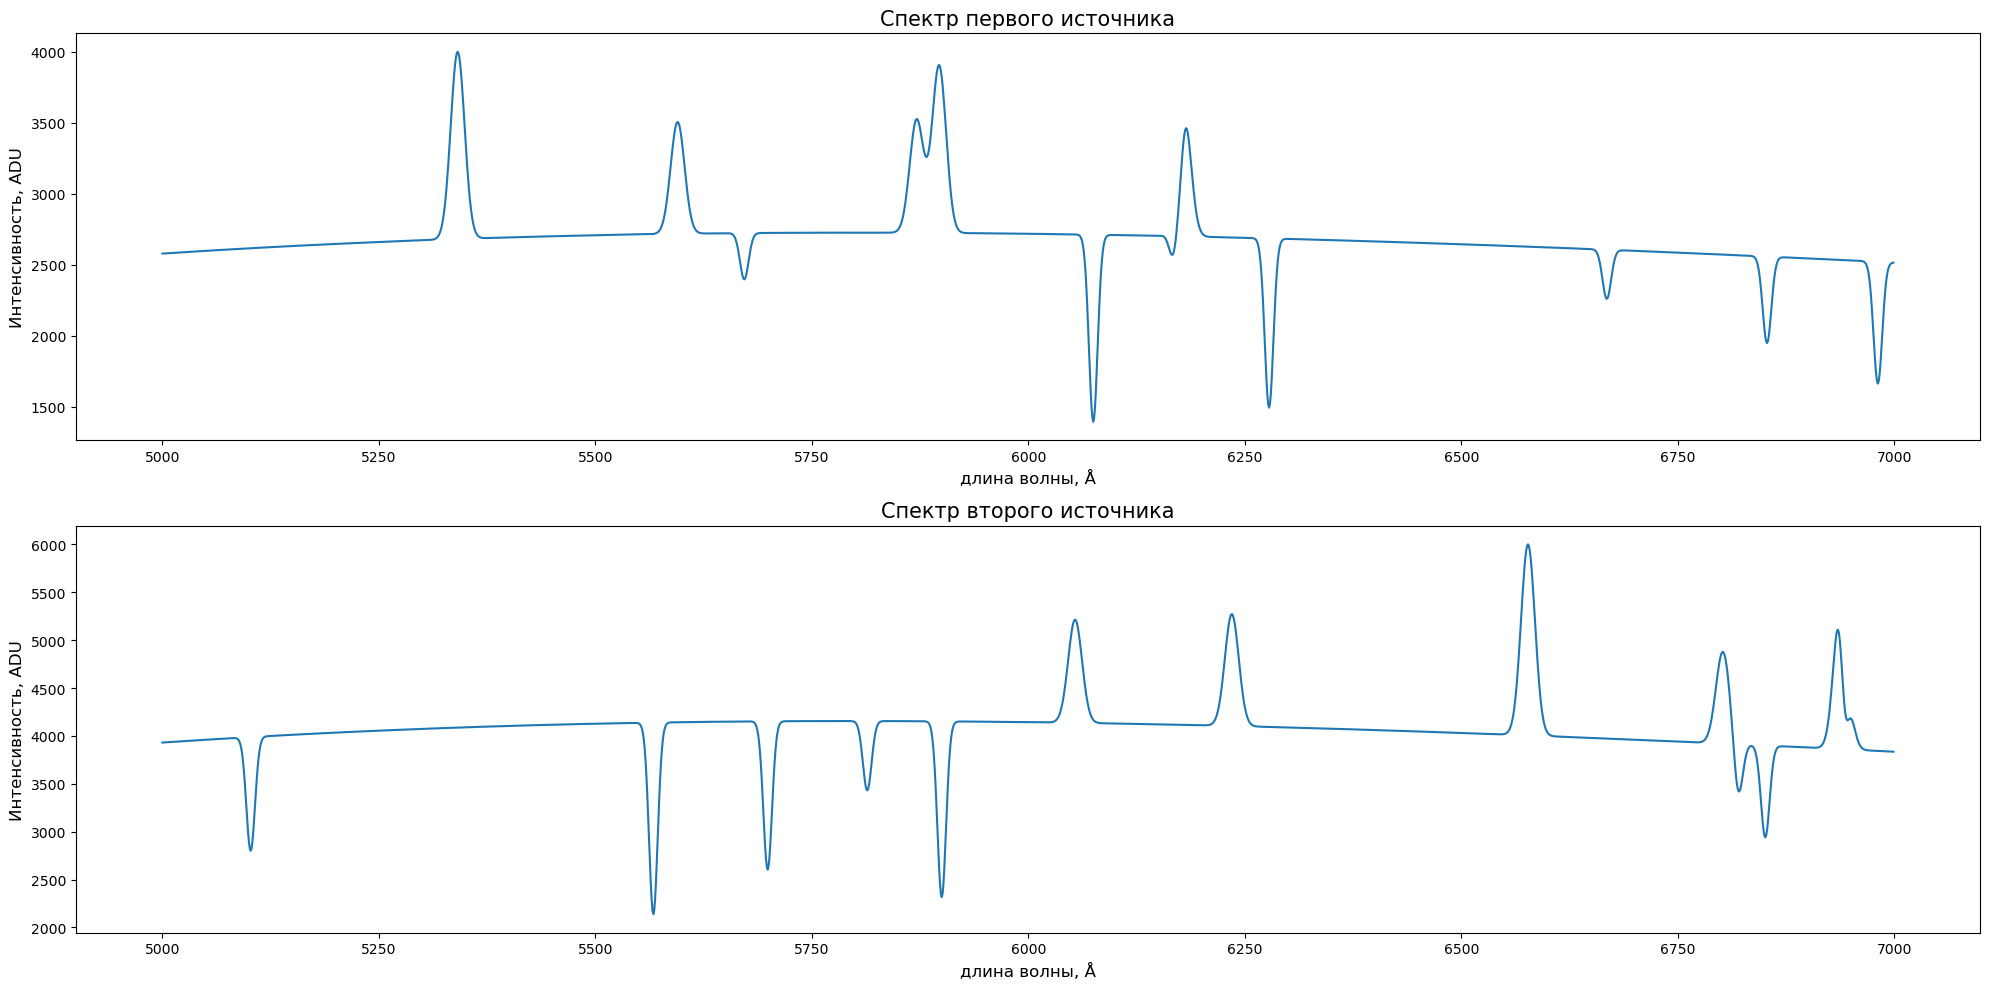

In [2]:
image, PSF, Lambda1, Int1, Lambda2, Int2 = Frame_model(slit, seeing, sep, pix_size, T1, T2, CRVAL1, image_size_X,
                                                       image_size_Y, Y_est, CDELT1, N_emission, N_absorption,
                                                       sigma_emission, sigma_absorption, MinMag_emission,
                                                       MinMag_absorption, MaxMag_emission, MaxMag_absorption,
                                                       MaxADU1, MaxADU2, RN, BN)


fig1, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].plot(Lambda1, Int1, '-', ms=3, mec='blue')
axes[0].set_xlabel("длина волны, Å", fontsize=12)
axes[0].set_ylabel("Интенсивность, ADU", fontsize=12)
axes[0].set_title("Спектр первого источника", fontsize=15)

axes[1].plot(Lambda2, Int2, '-', ms=3, mec='blue')
axes[1].set_xlabel("длина волны, Å", fontsize=12)
axes[1].set_ylabel("Интенсивность, ADU", fontsize=12)
axes[1].set_title("Спектр второго источника", fontsize=15)

plt.tight_layout()
plt.show()

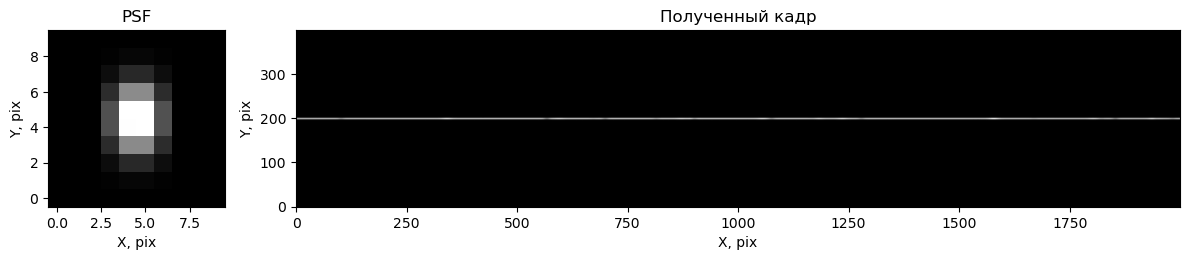

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 5]})

ax1.imshow(PSF, cmap='gray', origin='lower')
ax1.set_title('PSF')
ax1.set_xlabel('X, pix')
ax1.set_ylabel('Y, pix')

ax2.imshow(image, cmap='gray', origin='lower')
ax2.set_title('Полученный кадр')
ax2.set_xlabel('X, pix')
ax2.set_ylabel('Y, pix')

plt.tight_layout()
plt.show()

## Спектроастрометрическая обработка

Для получения кривой *спектроастрометрического эффекта* (зависимости положения центра спектра на кадре от длины волны) используется функция `Center_search`. Она также возвращает наблюдаемый спектр системы, зависимость его полуширины от длины волны и погрешности определения центра, для которого используется аппроксимация профиля яркости кривой Гаусса на каждой длине волны. Эта погрешность вычисляется согласно [Condon, 1977](https://ui.adsabs.harvard.edu/abs/1997PASP..109..166C/abstract) по формуле $$ \delta = 0.6 \frac{FWHM}{SNR} $$, где FWHM - полуширина спектра, SNR - отношение сигнал/шум.

Полуширина спектра в предлагаемом здесь методе обработки нужна только для вычисления погрешности аппроксимации. Однако она выводится отдельно, потому что может быть полезна для других методов (см. [Porter et al. 2004](https://ui.adsabs.harvard.edu/abs/2004A%26A...428..327P/abstract))

Функция `Center_search` позволяет исследовать как спектр целиком, так и любой диапазон входящих в него длин волн. Здесь выбрана область с отступом в 2 пикселя от краев спектра.

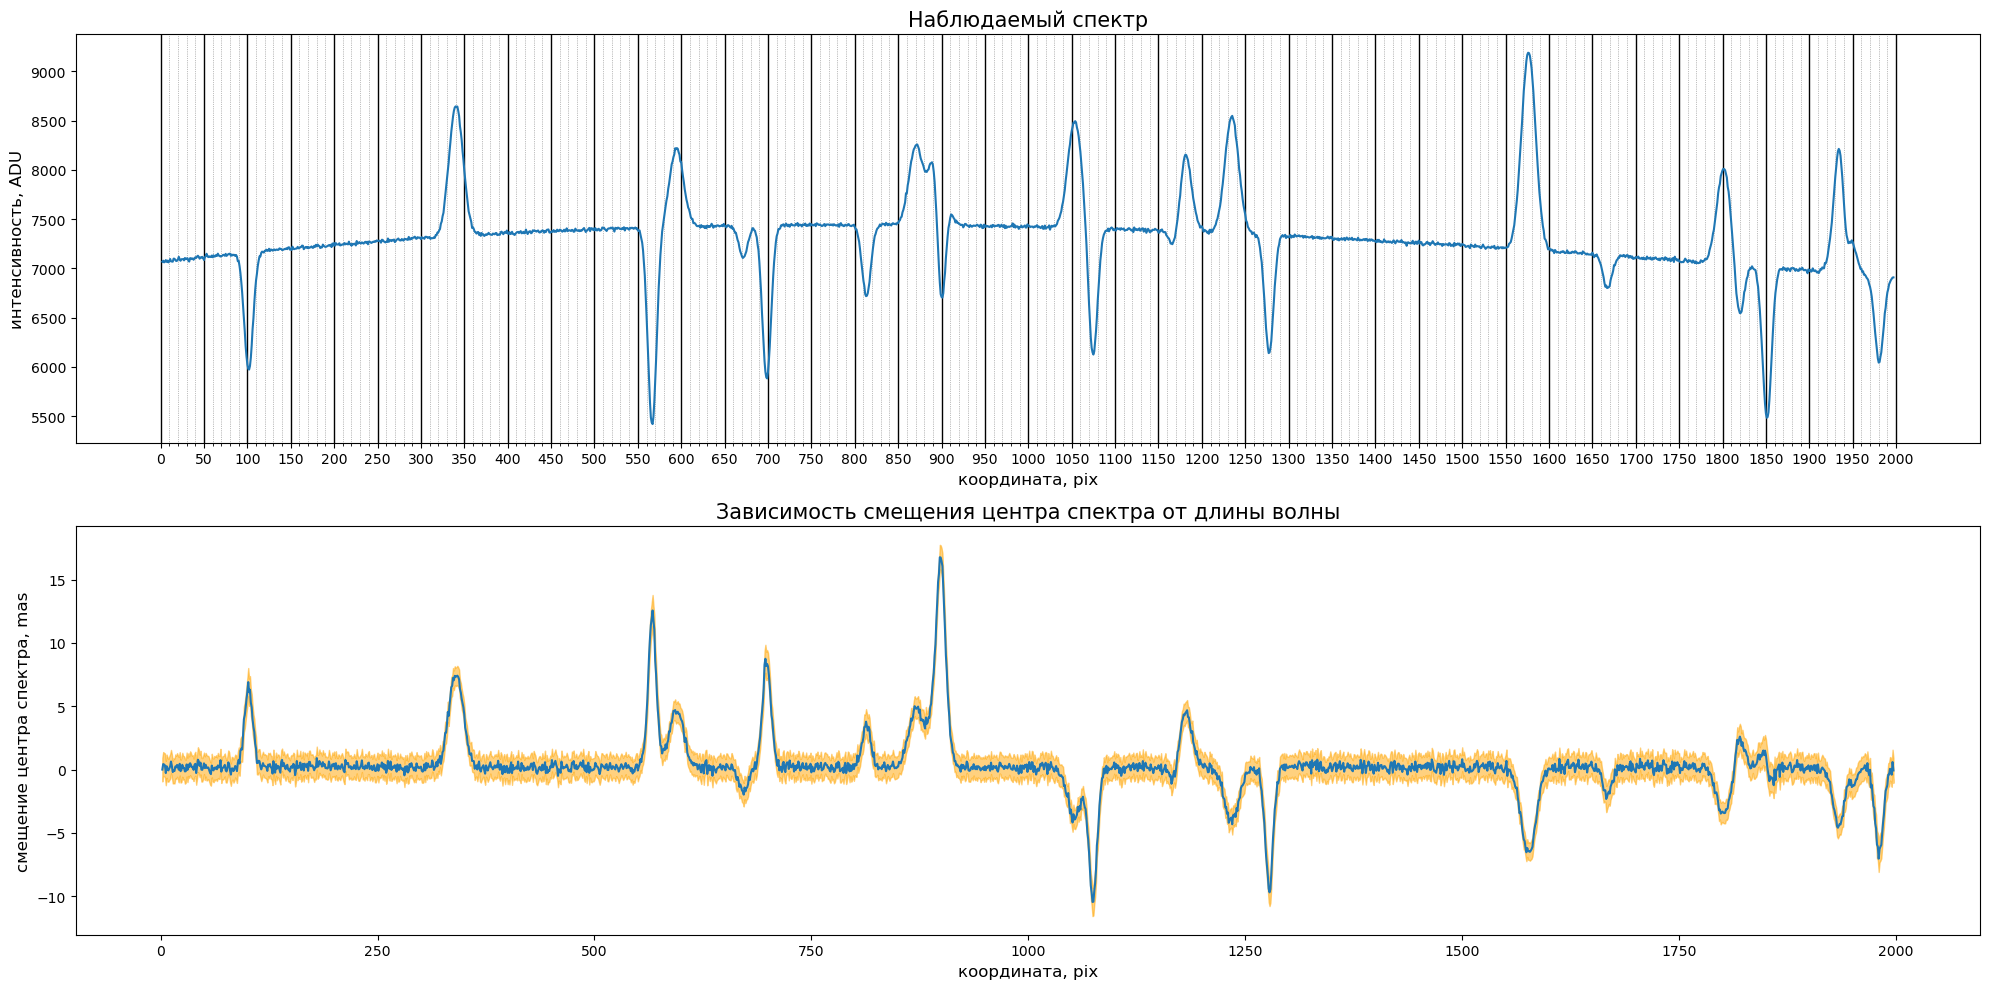

In [4]:
start = 2  # Отступ от левого края спектра
end = image_size_X - 2  # Отступ от правого края спектра
area = 20  # полуширина области поперек направления дисперсии, в которой проводится аппроксимация спектра

LAMBDA, SPEC, CENTER, FWHM, ERRORBAR = Center_search(CRVAL1, CDELT1, start, end, area, Y_est, image)


fig2, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].plot((LAMBDA - CRVAL1) / CDELT1, SPEC, '-', ms=3, mec='blue')
axes[0].set_xlabel("координата, pix", fontsize=12)
axes[0].set_ylabel("интенсивность, ADU", fontsize=12)
axes[0].set_title("Наблюдаемый спектр", fontsize=15)

axes[0].set_xticks(np.arange(0, 2001, 10), minor=True) 
axes[0].grid(which='minor', linestyle=':', linewidth=0.5, color='gray', axis='x')

axes[0].set_xticks(np.arange(0, 2001, 50))
axes[0].grid(which='major', linestyle='-', linewidth=1, color='black', axis='x')

CENTER1 = (CENTER - CENTER[0]) * pix_size * 1000  # Здесь для наглядности смещение отсчитывается центра первого среза
ERRORBAR1 = ERRORBAR * pix_size * 1000  # Перевод погрешности в микросекунды дуги

axes[1].plot((LAMBDA - CRVAL1) / CDELT1, CENTER1, '-', ms=3, mec='blue')
axes[1].fill_between((LAMBDA - CRVAL1) / CDELT1, CENTER1 - ERRORBAR1, CENTER1 + ERRORBAR1, color='orange', alpha=0.5)
axes[1].set_xlabel("координата, pix", fontsize=12)
axes[1].set_ylabel("смещение центра спектра, mas", fontsize=12)
axes[1].set_title("Зависимость смещения центра спектра от длины волны", fontsize=15)

plt.tight_layout()
plt.show()

Текущий метод предполагает оценку разделения компонент исследуемой системы путем определения центров отдельных спектральных линий, "очищенных" от излучения континуума. Он реализуется с помощью функции `Line_center_search`. Помимо упомянутых ранее величин она требует указать 2 числа: координату линии и координату области, выбранной в качестве континуума (эти координаты отсчитываются в пикселях вдоль направления дисперсии). Результатом работы функции является массив, содержащий параметры гауссовой аппроксимации линии: полный интеграл интенсивности, стандартное отклонение, среднее значение и начальный фон.

Координаты линий и континуумов определяются визуально по наблюдаемому спектру (см. график выше). Чтобы узнать принадлежность линии к той или иной компоненте системы, нужно сопоставить полученный спектр и спектроастрометрический эффект. Линии эмиссии будут отклонять центр спектра в сторону излучающего их объекта, а линии абсорбции - в противоположную сторону.

In [5]:
Line_1, error_1 = Line_center_search(image, 340, 320, Y_est, area)
Center_1 = Line_1[2]

Line_2, error_2 = Line_center_search(image, 340, 360, Y_est, area)
Center_2 = Line_2[2]

Line_3, error_3 = Line_center_search(image, 1575, 1550, Y_est, area)
Center_3 = Line_3[2]

Line_4, error_4 = Line_center_search(image, 1575, 1600, Y_est, area)
Center_4 = Line_4[2]

# Взвешенное среднее
Cent_1 = (Center_1 / error_1**2 + Center_2 / error_2**2) / (1 / error_1**2 + 1 / error_2**2)
Cent_2 = (Center_3 / error_3**2 + Center_4 / error_4**2) / (1 / error_3**2 + 1 / error_4**2)

print('\n')
print(' Линия |            Смещение           ')
print('---------------------------------------')
print(340 * CDELT1 + CRVAL1, 'Å |', (Center_1 - Cent_1) * pix_size, 'arcsec')
print(340 * CDELT1 + CRVAL1, 'Å |', (Center_2 - Cent_1) * pix_size, 'arcsec')
print(1575 * CDELT1 + CRVAL1, 'Å |', (Center_3 - Cent_1) * pix_size, 'arcsec')
print(1575 * CDELT1 + CRVAL1, 'Å |', (Center_4 - Cent_1) * pix_size, 'arcsec')

discr = len(PSF[0]) * pix_size / 1200  # Погрешность, связанная с дискретизацией модели
delta_1 = np.sqrt(1 / 2 * ((Cent_1 - Center_1)**2 + (Cent_1 - Center_2)**2)) + discr   # Учет разброса данных
delta_2 = np.sqrt(1 / 2 * ((Cent_2 - Center_3)**2 + (Cent_2 - Center_4)**2)) + discr

sep = abs(Cent_1 - Cent_2) * pix_size  # Оценка разделения источников
delta = (delta_1 + delta_2) * pix_size  # Итоговая погрешность

print('\nsep =', sep, '+/-', delta, 'arcsec')



 Линия |            Смещение           
---------------------------------------
5340 Å | -0.0001847632920544129 arcsec
5340 Å | 0.0017344165465161155 arcsec
6575 Å | -0.07116633649504195 arcsec
6575 Å | -0.07059204506981188 arcsec

sep = 0.0711351368521892 +/- 0.003899680571272483 arcsec


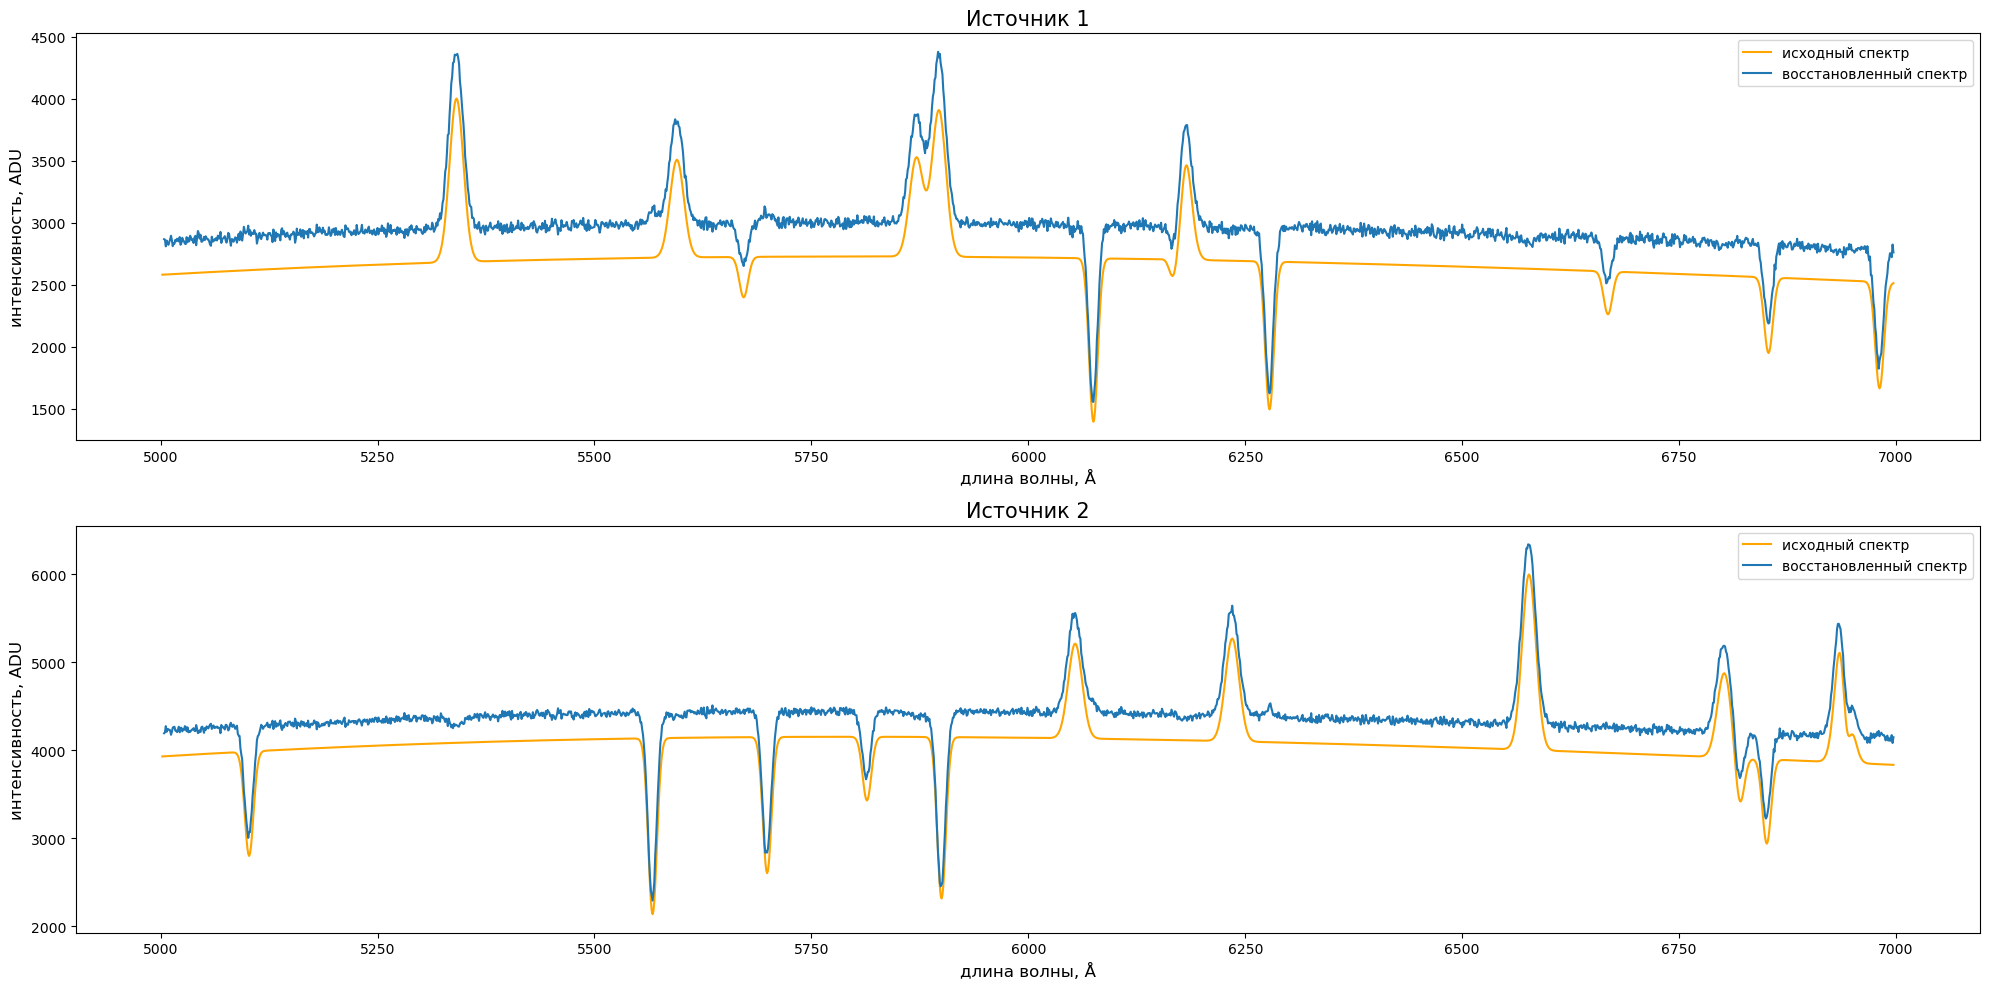

In [6]:
# Восстановление спектров

SPEC1 = np.zeros(end - start)
SPEC2 = np.zeros(end - start)

for i in range(end - start):
    SPEC1[i] = ((Cent_1 - CENTER[i]) * pix_size / sep) * SPEC[i]  # Здесь из Cent_1 или Cent_2 выбирается наибольший
    SPEC2[i] = SPEC[i] - SPEC1[i]


fig2, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].plot(Lambda1[start:end], abs(Int1[start:end]), '-', ms=2, color='orange', label='исходный спектр')
axes[0].plot(LAMBDA[start:end], abs(SPEC2[start:end]), '-', ms=2, label='восстановленный спектр')
axes[0].set_xlabel("длина волны, Å", fontsize=12)
axes[0].set_ylabel("интенсивность, ADU", fontsize=12)
axes[0].set_title("Источник 1", fontsize=15)
axes[0].legend()

axes[1].plot(Lambda2[start:end], abs(Int2[start:end]), '-', ms=2, color='orange', label='исходный спектр')
axes[1].plot(LAMBDA[start:end], abs(SPEC1[start:end]), '-', ms=2, label='восстановленный спектр')
axes[1].set_xlabel("длина волны, Å", fontsize=12)
axes[1].set_ylabel("интенсивность, ADU", fontsize=12)
axes[1].set_title("Источник 2", fontsize=15)
axes[1].legend()

plt.tight_layout()
plt.show()

Здесь разделение спектров определялось по двум линиям, причем для каждой из них континуум оценивался дважды - по областям слева и справа от линии. Это позволяет уменьшить вероятность отклонений, связанных с шумами. Тем не менее иногда шумы могут приводить к относительно большому отклонению центра аппроксимирующей кривой от истинного центра линии, что в случае малого числа обрабатываемых линий может привести к недооценке погрешности. Поэтому при обработке реальных данных следует брать либо как можно большее число линий, относящихся к каждому из источников, либо подробно изучать отклонения в каждой из рассматриваемых линий при разных значениях континуума.

Ниже приведен пример такого изучения одной из линий. 

In [7]:
Line_0, error0 = Line_center_search(image, 340, 320, Y_est, area)
Center_0 = Line_0[2]

Line_1, error1 = Line_center_search(image, 340, 325, Y_est, area)
Center_1 = Line_1[2]

Line_2, error2 = Line_center_search(image, 340, 330, Y_est, area)
Center_2 = Line_2[2]

Line_3, error3 = Line_center_search(image, 340, 335, Y_est, area)
Center_3 = Line_3[2]

Line_4, error4 = Line_center_search(image, 340, 345, Y_est, area)
Center_4 = Line_4[2]

Line_5, error5 = Line_center_search(image, 340, 350, Y_est, area)
Center_5 = Line_5[2]

Line_6, error6 = Line_center_search(image, 340, 355, Y_est, area)
Center_6 = Line_6[2]

Line_7, error7 = Line_center_search(image, 340, 360, Y_est, area)
Center_7 = Line_7[2]

Cent = (Center_0  + Center_1  + Center_2 + Center_3  + Center_4 + Center_5  + Center_6 + Center_7) / 8

print('\n')
print('Континуум  |          Смещение            ')
print('------------------------------------------')
print(320 * CDELT1 + CRVAL1, 'Å     |', (Center_0 - Cent) * pix_size, 'arcsec')
print(325 * CDELT1 + CRVAL1, 'Å     |', (Center_1 - Cent) * pix_size, 'arcsec')
print(330 * CDELT1 + CRVAL1, 'Å     |', (Center_2 - Cent) * pix_size, 'arcsec')
print(335 * CDELT1 + CRVAL1, 'Å     |', (Center_3 - Cent) * pix_size, 'arcsec')
print(345 * CDELT1 + CRVAL1, 'Å     |', (Center_4 - Cent) * pix_size, 'arcsec')
print(350 * CDELT1 + CRVAL1, 'Å     |', (Center_5 - Cent) * pix_size, 'arcsec')
print(355 * CDELT1 + CRVAL1, 'Å     |', (Center_6 - Cent) * pix_size, 'arcsec')
print(360 * CDELT1 + CRVAL1, 'Å     |', (Center_7 - Cent) * pix_size, 'arcsec')



Континуум  |          Смещение            
------------------------------------------
5320 Å     | 0.00010534909528928438 arcsec
5325 Å     | 0.00237266891591247 arcsec
5330 Å     | 0.001471663817195008 arcsec
5335 Å     | -0.011723252657242255 arcsec
5345 Å     | 0.0047310675831298 arcsec
5350 Å     | -0.0008369571120041997 arcsec
5355 Å     | 0.0018549314238180158 arcsec
5360 Å     | 0.0020245289338598127 arcsec


Видно, что среди полученных значений есть как величины, близкие к какой-то одной координате, так и небольшие "выбросы", отличающиеся от большинства результатов. Координаты континуумов, соответствующие последним, не следует учитывать при обработке.